# Recepit Count Forecasting Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
plt.rcParams['figure.figsize'] = (8, 6)
import torch
import torch.nn as nn
import torch.optim as optim


In [2]:
import random

seed = 42
random.seed(seed)  # Python
np.random.seed(seed)  # Numpy
torch.manual_seed(seed)  # PyTorch

#### Read in Data


In [3]:
df = pd.read_csv("data/data_daily.csv")
print(f"The dataset has {df.shape[0]} records, and {df.shape[1]} features.")

The dataset has 365 records, and 2 features.


# Feature Selection 
Let's check the datatypes of our features


In [4]:
df.dtypes

# Date           object
Receipt_Count     int64
dtype: object

We see that the Date is currently of type object, so let's convert it to a Datatime object which will be helpful in the upcoming steps.

In [5]:
# remove the # from the column name
df.rename(columns={'# Date': 'Date'}, inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)


Let's extract some granular information from the date object in order to better understand patterns in our data:
- **Day (`day`)**
  
- **Month (`month`)**
   
- **Year (`year`)**
   
- **Weekday (`weekday`)**
   
- **Is Weekend (`is_weekend`)**
  
- **Quarter (`quarter`)**

- **Day of the Year (`day_of_year`)**
  

  
*Also, let's convert these to `np.float64`*

In [6]:
df["day"] = df.index.day.astype(np.float64)
df["month"] = df.index.month.astype(np.float64)
df["year"] = df.index.year.astype(np.float64)
df["weekday"] = df.index.weekday.astype(np.float64)
df["is_weekend"] = df["weekday"].apply(lambda x: 1 if x >= 5 else 0).astype(np.float64)
df["quarter"] = df.index.quarter.astype(np.float64)
df["day_of_week"] = df.index.dayofweek.astype(np.float64)
df["day_of_year"] = df.index.dayofyear.astype(np.float64)
df.Receipt_Count = df.Receipt_Count.astype(np.float64)            

This is what the data types look like now

In [7]:
df.dtypes

Receipt_Count    float64
day              float64
month            float64
year             float64
weekday          float64
is_weekend       float64
quarter          float64
day_of_week      float64
day_of_year      float64
dtype: object

In [8]:
df.head()

,Receipt_Count,day,month,year,weekday,is_weekend,quarter,day_of_week,day_of_year
Date,,,,,,,,,
2021-01-01,7564766.0,1.0,1.0,2021.0,4.0,0.0,1.0,4.0,1.0
2021-01-02,7455524.0,2.0,1.0,2021.0,5.0,1.0,1.0,5.0,2.0
2021-01-03,7095414.0,3.0,1.0,2021.0,6.0,1.0,1.0,6.0,3.0
2021-01-04,7666163.0,4.0,1.0,2021.0,0.0,0.0,1.0,0.0,4.0
2021-01-05,7771289.0,5.0,1.0,2021.0,1.0,0.0,1.0,1.0,5.0


### Visualize Data
Let us first plot the graph of each independent variable against the target variable (`Receipt_Count`).

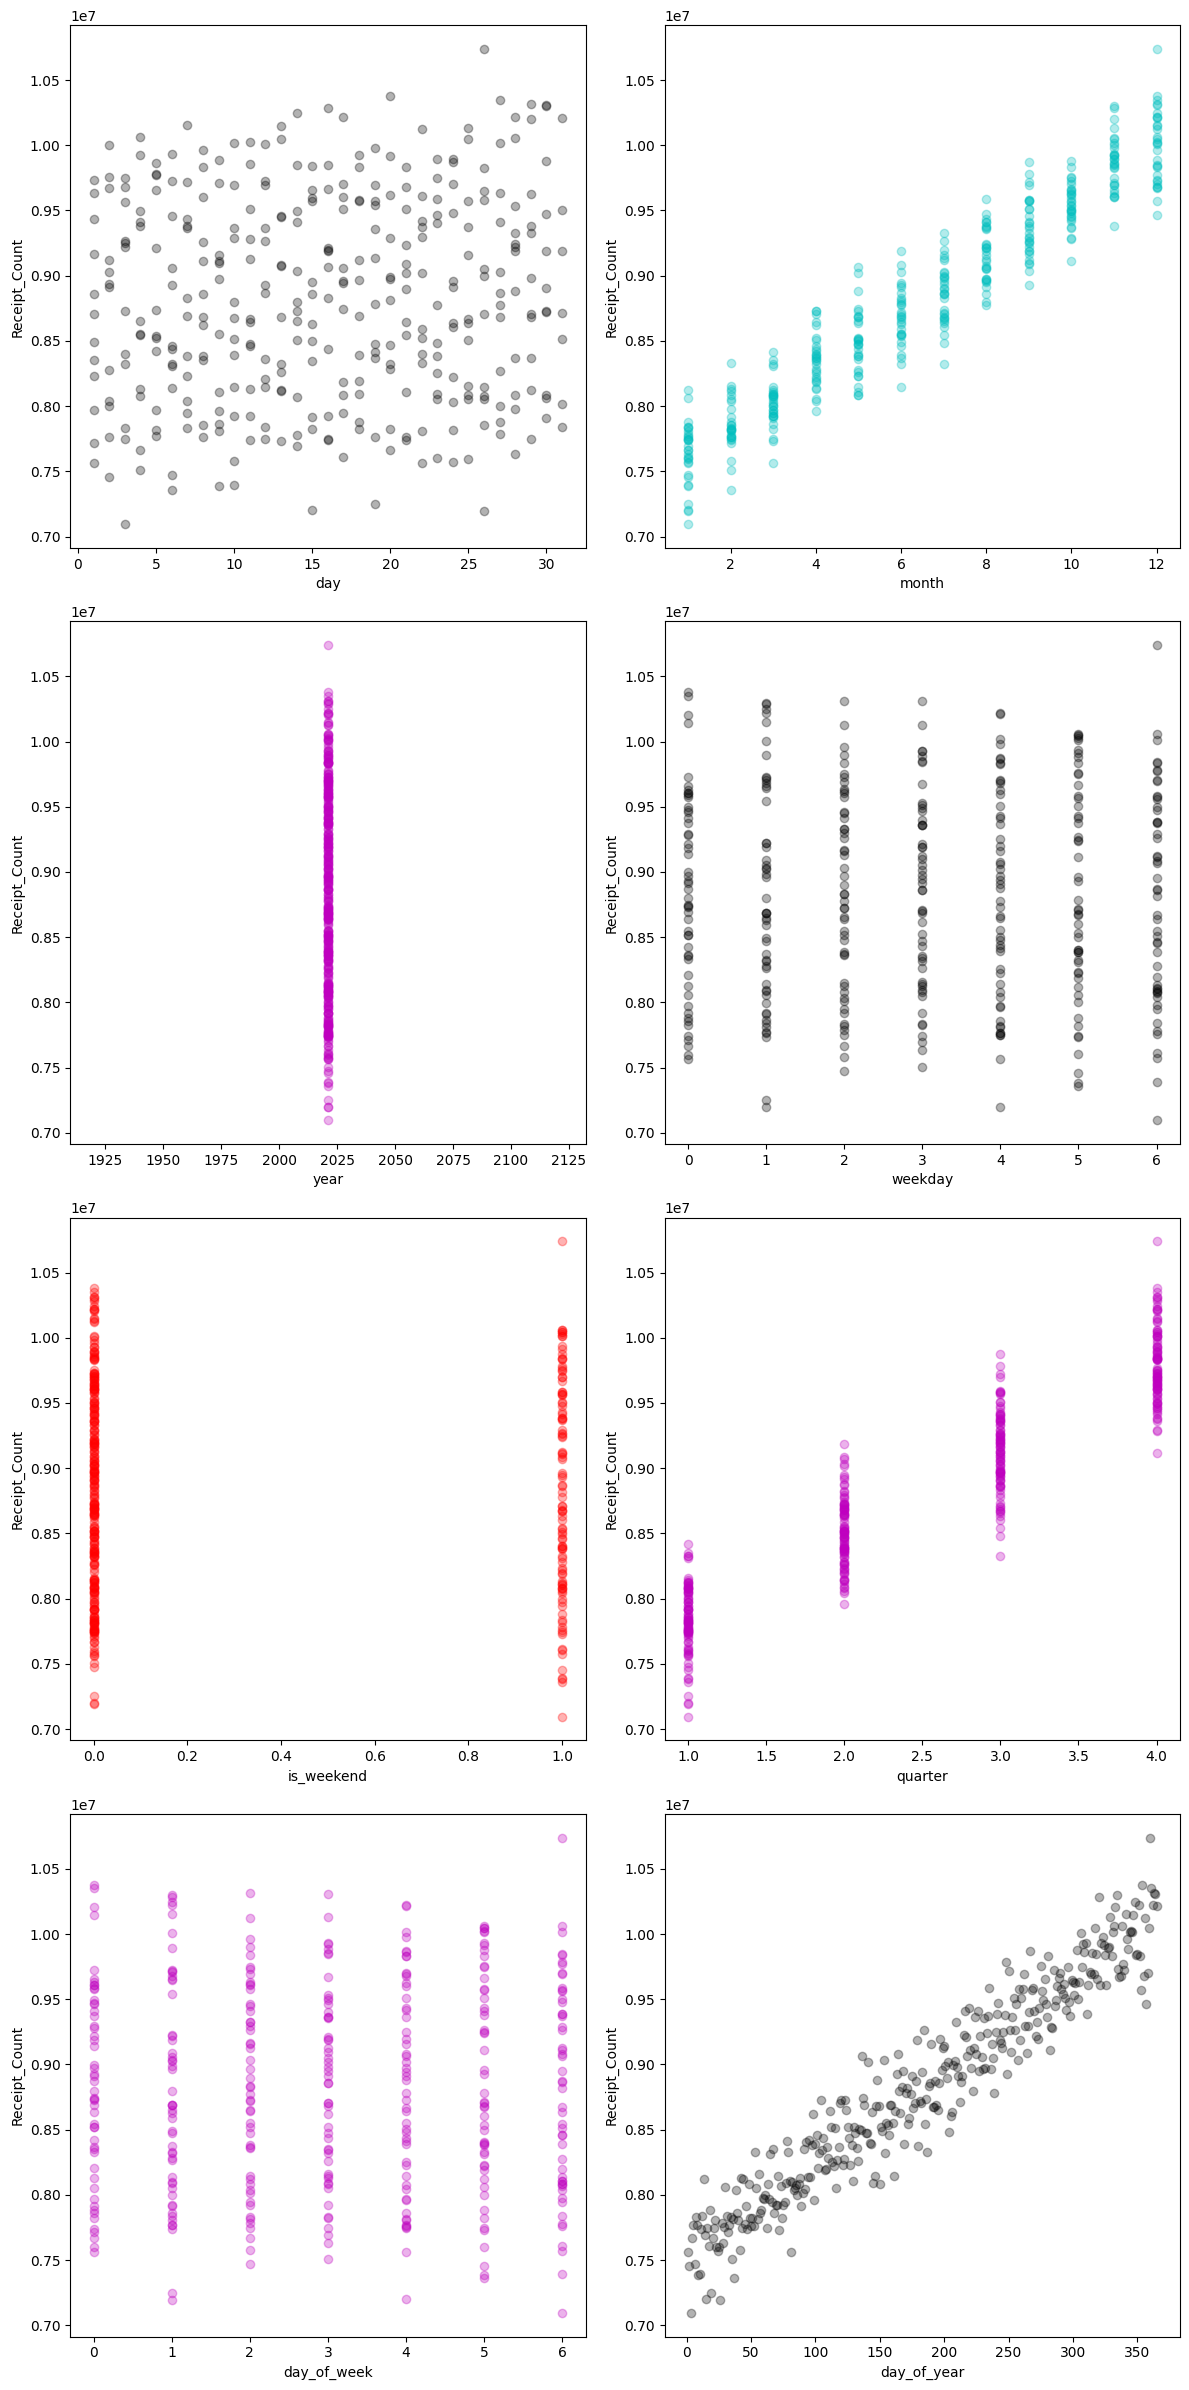

In [9]:
# Function for plotting independent variables against target variable
# fig, a =  plt.subplots(3, figsize = (5, 5*3))
def plotter(column_list, target_col, df):
    """Plots scatterplot for each independent variable against the target variable
    
    Args-
        column_list- List containing names of all the dependent variables
        target_col- Name of the target variable
        df- The dataframe
    Returns-
        None
    """
    n = len(column_list)
    color = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] # list of color values
    
    # Calculate number of rows based on the number of plots. Using ceil for odd numbers.
    rows = int(np.ceil(n/2.0))
    
    fig, axes = plt.subplots(rows, 2, figsize=(12, 6*rows))
    
    # Flattening the 2D array of axes
    flat_axes = axes.ravel()
    
    for i, col in enumerate(column_list):
        ax = flat_axes[i]
        ax.scatter(df[col], df[target_col], alpha=0.3, c=np.random.choice(color))
        ax.set_xlabel(col)
        ax.set_ylabel(target_col)
        
        # If n is odd, remove the last (unused) subplot
        if n%2 != 0 and i == len(column_list) - 1:
            fig.delaxes(flat_axes[-1])
    
    plt.tight_layout()
    plt.show()


# creates a list of all the columns except the target column
cols_list = list(df.columns)
cols_list.remove('Receipt_Count')

# Target variable holds the name of the target variable
target_col = 'Receipt_Count'

plotter(cols_list, target_col, df)

It looks like the `year` column is not providing any variance to the data. Let's drop it.

In [10]:
df.drop(columns=["year"], inplace=True)

Now, let us have a look at the correlation values for our dataset.

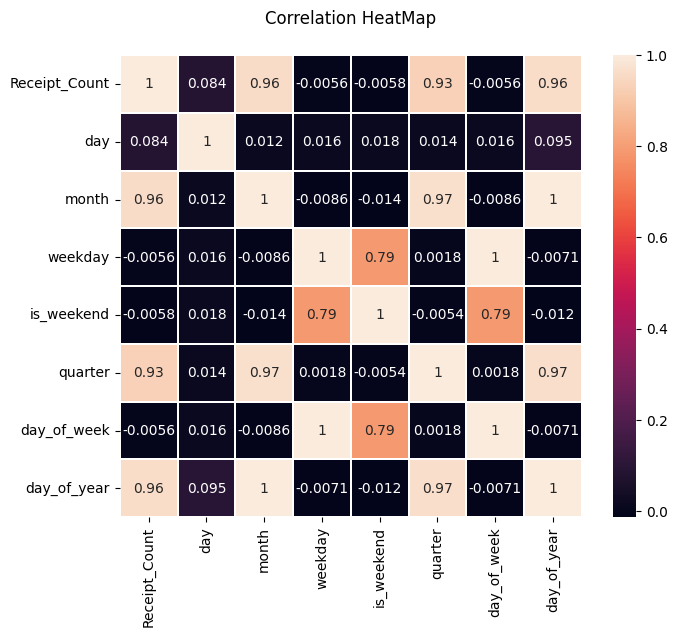

In [11]:
# plots a correlation heatmap

plt.title('Correlation HeatMap', y = 1.05)
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=True)
plt.show()

From the above visual analysis, we can see that **day_of_year** (++0.96), **quarter** (+0.93) and **month** (+0.96) show a very strong correlation with the dependent variable, **Receipt_Count**.

However, **month** and **quarter** show a strong correlation  between themselves as well. Such Multi Collinearilty could create an overfitting scenario if we are to go ahead and build a simple Regression Model

# Feature Engineering

In [12]:
df.Receipt_Count.min()

7095414.0

#### Scale Dependent Variable, `Receipt_Count`
Let's first visualize the distribution 

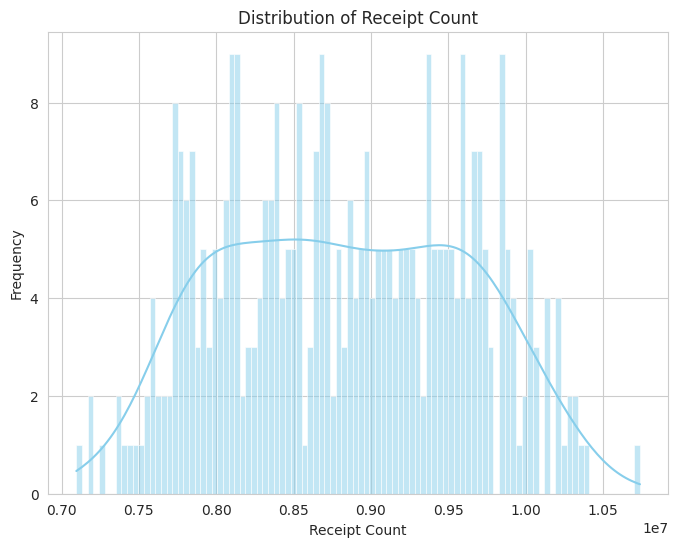

In [13]:
sns.set_style('whitegrid')
sns.histplot(df.Receipt_Count, bins=100, color='skyblue', kde=True)
plt.title('Distribution of Receipt Count')
plt.xlabel('Receipt Count')
plt.ylabel('Frequency')
plt.show()


In the data we have, the Receipt_Count Column has values in the magnitude of millions. With the largest count for a day being 10738865 and the smallest count for a day being 7095414. This will get even greater when we try to make forecasts for months in the following year. Ideally for building a model, it is better if the data is in a smaller range. Let's explore some possible options to scale the data. 

##### Min-Max Scaling
This method can be used to scale data between 0 and 1, however, there are certain outliers in the data. Hence this method will not be very effective here

##### Standard Scaling (Z-score)
This method centers the data around 0 and scales based on the standard deviation. It's less sensitive to small standard deviations than Min-Max scaling and is less affected by outliers. However, this method is good if the data follows a Gaussian Distribution. 

Looking at the Distribution plot above, it does not look like the data follows a Gaussian Distribution. 

To further verify, let's runa  statistical test with a null hypothesis that the data is drawn from a normal distribution.. If we get a p-value greater than 0.05, we can conduct some further analysis on the assumption that it comes froma  Gaussian Distribution. 

In [14]:
stat, p = shapiro(df.Receipt_Count)
print(f"P-value: {p}")
if p > 0.05:
    print('Sample looks Gaussian')
else:
    print('Sample does not look Gaussian')

P-value: 1.4178785022522788e-05
Sample does not look Gaussian


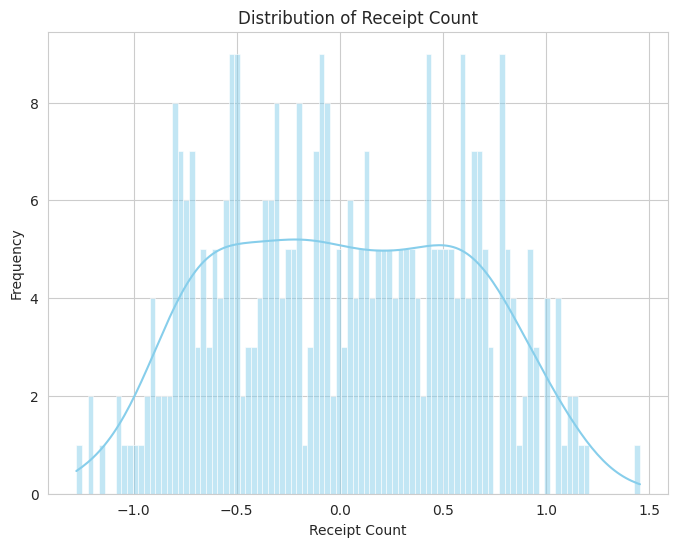

In [15]:
def robust_scaler(data):
    """
    Scales the given data using the interquartile range.
    
    Args:
    - data (list or numpy array): The input data to be scaled.
    
    Returns:
    - numpy array: The robustly scaled data.
    """
    # Convert the input data to numpy array for computation
    data = np.array(data)
    
    # Calculate the first (25th percentile) and third quartile (75th percentile)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    
    # Calculate the interquartile range
    IQR = Q3 - Q1
    
    # Calculate the median
    median = np.median(data)
    
    # Scale the data
    scaled_data = (data - median) / IQR

    # Metadata for inverse scaling
    metadata = {
        "median": median,
        "IQR": IQR
    }
    
    return scaled_data, metadata

def inverse_robust_scaling(scaled_data, metadata):
    """
    Converts the scaled data back to its original scale using the provided metadata.
    
    Args:
    - scaled_data (list or numpy array): The data to be inverse transformed.
    - metadata (dict): The metadata for inverse scaling.
    
    Returns:
    - numpy array: The data in its original scale.
    """
    # Extract the median and IQR from the metadata
    median = metadata["median"]
    IQR = metadata["IQR"]
    
    # Inverse transform the data
    original_data = (scaled_data * IQR) + median
    
    return original_data

scaled_data, metadata = robust_scaler(df.Receipt_Count)

df["scaled_Receipt_Count"] = scaled_data
# # To inverse transform a single record (or multiple records)
# original_value = inverse_robust_scaling(scaled_data[0], metadata)


sns.set_style('whitegrid')
sns.histplot(scaled_data, bins=100, color='skyblue', kde=True)
plt.title('Distribution of Receipt Count')
plt.xlabel('Receipt Count')
plt.ylabel('Frequency')
plt.show()

#### Scale Independent Variables

From the above analysis, let us pick the following columns for model building:
- `month`
- `day_of_year`
- `quarter`

In [16]:
print(df.columns)
def scale_to_01_range(values, min_val, max_val):
    """Scale a list of values to [0, 1] range."""
    return [(v - min_val) / (max_val - min_val) for v in values]


# Scale month from 0-1
min_month = df.month.min()
max_month = df.month.max()
df['scaled_month'] = scale_to_01_range(df['month'], min_month, max_month)

# scale day_of_year from 0-1
min_day_of_year = df.day_of_year.min()
max_day_of_year = df.day_of_year.max()
df['scaled_day_of_year'] = scale_to_01_range(df['day_of_year'], 1, 365)

# One-hot encode the quarter column
quarter_dummies = pd.get_dummies(df['quarter'], prefix='quarter')
df = pd.concat([df, quarter_dummies], axis=1)
# Convert boolean columns to float
for col in ['quarter_1.0', 'quarter_2.0', 'quarter_3.0', 'quarter_4.0']:
    df[col] = df[col].astype(np.float64)


# create a new dataframe
scaled_df = df[['month', 'scaled_day_of_year', 'scaled_month', 'quarter_1.0', 'quarter_2.0', 'quarter_3.0', 'quarter_4.0', 'scaled_Receipt_Count']]
scaled_df.dtypes

Index(['Receipt_Count', 'day', 'month', 'weekday', 'is_weekend', 'quarter',
       'day_of_week', 'day_of_year', 'scaled_Receipt_Count'],
      dtype='object')


month                   float64
scaled_day_of_year      float64
scaled_month            float64
quarter_1.0             float64
quarter_2.0             float64
quarter_3.0             float64
quarter_4.0             float64
scaled_Receipt_Count    float64
dtype: object

In [17]:
scaled_df

,month,scaled_day_of_year,scaled_month,quarter_1.0,quarter_2.0,quarter_3.0,quarter_4.0,scaled_Receipt_Count
Date,,,,,,,,
2021-01-01,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,-0.925333
2021-01-02,1.0,0.002747,0.0,1.0,0.0,0.0,0.0,-1.007218
2021-01-03,1.0,0.005495,0.0,1.0,0.0,0.0,0.0,-1.277146
2021-01-04,1.0,0.008242,0.0,1.0,0.0,0.0,0.0,-0.849329
2021-01-05,1.0,0.010989,0.0,1.0,0.0,0.0,0.0,-0.770529
...,...,...,...,...,...,...,...,...
2021-12-27,12.0,0.989011,1.0,0.0,0.0,0.0,1.0,1.162704
2021-12-28,12.0,0.991758,1.0,0.0,0.0,0.0,1.0,1.064538
2021-12-29,12.0,0.994505,1.0,0.0,0.0,0.0,1.0,1.134917


# Model Building

Let's start by creating a simple Linear Regression Model of the form, 
$$ \text{Receipt\_count} = \text{day\_of\_year} \times m + \text{bias} $$


In [18]:
def r2_score(target, prediction):
    """Calculates the r2 score of the model
    
    Args-
        target- Actual values of the target variable
        prediction- Predicted values, calculated using the model
        
    Returns- 
        r2- r-squared score of the model
    """
    r2 = 1- torch.sum((target-prediction)**2) / torch.sum((target-target.float().mean())**2)
    return r2



Epoch [100/1000], Loss: 0.0436
Epoch [200/1000], Loss: 0.0375
Epoch [300/1000], Loss: 0.0375
Epoch [400/1000], Loss: 0.0375
Epoch [500/1000], Loss: 0.0375
Epoch [600/1000], Loss: 0.0375
Epoch [700/1000], Loss: 0.0375
Epoch [800/1000], Loss: 0.0375
Epoch [900/1000], Loss: 0.0375
Epoch [1000/1000], Loss: 0.0375
Test Loss: 0.0499
r-squared score = -0.13121774078035076


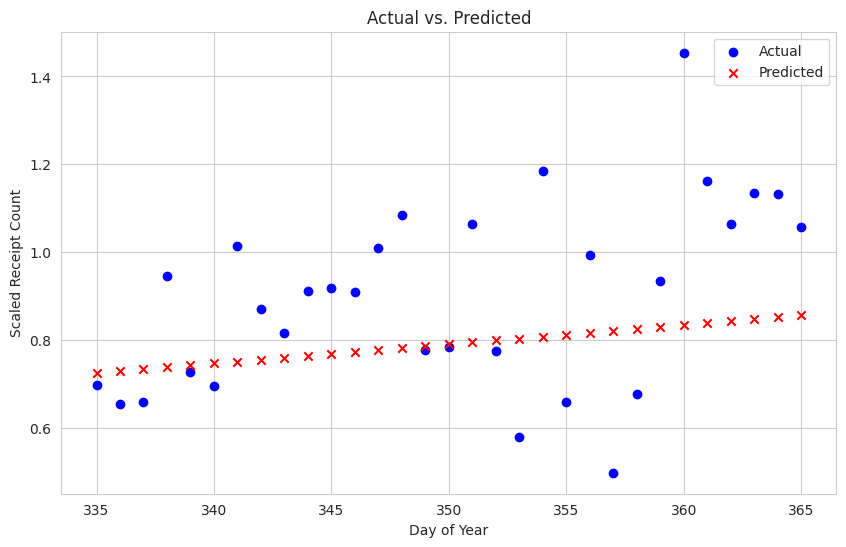

In [23]:
TRAIN_DATA_MONTHS = 11 # the number of months to use for training
# Step 1: Create datasets
train_data = df[df['month'] <= TRAIN_DATA_MONTHS]  # First 9 months for training
test_data = df[df['month'] > TRAIN_DATA_MONTHS]    # Last 3 months for testing


X_train = torch.tensor(train_data['day_of_year'].values, dtype=torch.float64).view(-1, 1)
y_train = torch.tensor(train_data['scaled_Receipt_Count'].values, dtype=torch.float64).view(-1, 1)

X_test = torch.tensor(test_data['day_of_year'].values, dtype=torch.float64).view(-1, 1)
y_test = torch.tensor(test_data['scaled_Receipt_Count'].values, dtype=torch.float64).view(-1, 1)


# Step 2: Define the Linear Regression model
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

model = LinearRegression(1, 1)
model.double()

# Step 3: Set loss criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.000001)


# Step 4: Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f"Test Loss: {test_loss.item():.4f}")


print("r-squared score = {}".format(r2_score(y_test, y_pred)))

# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(X_test.numpy(), y_test, color='blue', label='Actual')
plt.scatter(X_test.numpy(), y_pred, color='red', marker='x', label='Predicted')
plt.xlabel('Day of Year')
plt.ylabel('Scaled Receipt Count')
plt.title('Actual vs. Predicted')
plt.legend()
plt.grid(True)
plt.show()


Epoch [1000/5000], Loss: 0.2518
Epoch [2000/5000], Loss: 0.2496
Epoch [3000/5000], Loss: 0.2474
Epoch [4000/5000], Loss: 0.2452
Epoch [5000/5000], Loss: 0.2430
Test Loss: 0.2430
r-squared score = 0.29077076262172386


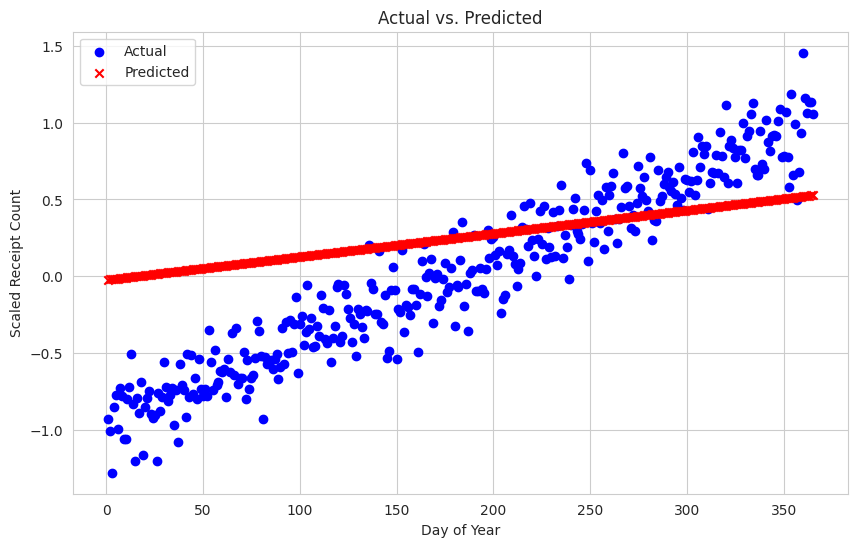

In [33]:
TRAIN_DATA_MONTHS = 12 # the number of months to use for training
# Step 1: Create datasets
train_data = df[df['month'] <= TRAIN_DATA_MONTHS]  # First 9 months for training
test_data = df[df['month'] > TRAIN_DATA_MONTHS]    # Last 3 months for testing


X_train = torch.tensor(train_data['day_of_year'].values, dtype=torch.float64).view(-1, 1)
y_train = torch.tensor(train_data['scaled_Receipt_Count'].values, dtype=torch.float64).view(-1, 1)

# X_test = torch.tensor(test_data['day_of_year'].values, dtype=torch.float64).view(-1, 1)
# y_test = torch.tensor(test_data['scaled_Receipt_Count'].values, dtype=torch.float64).view(-1, 1)


# Step 2: Define the Linear Regression model
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

model = LinearRegression(1, 1)
model.double()
nn.init.normal_(model.linear.weight, mean=0, std=0.01)
nn.init.zeros_(model.linear.bias)


# Step 3: Set loss criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.00001)


# Step 4: Train the model
num_epochs = 5000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    test_loss = criterion(y_pred, y_train)
    print(f"Test Loss: {test_loss.item():.4f}")
print("r-squared score = {}".format(r2_score(y_train, y_pred)))


# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(X_train.numpy(), y_train, color='blue', label='Actual')
plt.scatter(X_train.numpy(), y_pred, color='red', marker='x', label='Predicted')
plt.xlabel('Day of Year')
plt.ylabel('Scaled Receipt Count')
plt.title('Actual vs. Predicted')
plt.legend()
plt.grid(True)
plt.show()



In [25]:
y_pred.shape, y_train.shape

(torch.Size([365, 1]), torch.Size([365, 1]))